# Q-Learning

Q-learning snake using the simple technique Q-learning with a Q-Table and Experience Replay with a focus on replaying the experience when the snake dies (sort of Dying Specialized Experience Replay).

## Initialization

In [1]:
import os
import sys
import cv2
import IPython
from PIL import Image
from datetime import datetime
import multiprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np # linear algebra
from scipy.spatial import distance_matrix
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

In [2]:
COLOR = {"red": [234, 15, 25],
         "black": [8, 30, 7],
         "white": [224, 250, 248],
         "yellow": [237, 229, 36],
         "orange": [245, 204, 0],
         "grey": [129, 121, 137],
         "purple": [153, 0, 204],
         "green": [51, 214, 51],
         "pink": [266, 142, 204],
         "brown": [153, 102, 0], 
         "blue": [102, 102, 255],
         "marine": [8, 158, 170]}

In [3]:
LEARNING_STYLE = "q_learning"

## Environment

In [4]:
class Environment:
    # we consider grid values standardized in [0, 1]
    # we consider grid colors in RGB in lists such as [0, 128, 255]
    
    def __init__(self,
                 n_row=9, 
                 n_col=9,
                 agent_value = 0.66,
                 agent_head_value = 1,
                 food_value=0.33,
                 background_value=0,
                 agent_color = "yellow",
                 agent_head_color = "marine",
                 food_color = "red",
                 background_color = "black",
                 image_shape = (64, 64, 3),
                 reward_hit_wall=-500,
                 reward_eat_yourself=-500,
                 reward_move=-10,
                 reward_eat_food=100,
                 nn_input_mode="feature"):
        self.img_shape = image_shape
        self.feature_size = 12
        self.nn_input_mode = nn_input_mode
        self.nn_input_config = {"image": {"shape": self.img_shape, "pfunc": self.get_image_grid},
                             "feature": {"shape": self.feature_size, "pfunc": self.get_feature_state}}
        self.n_row = n_row
        self.n_col = n_col
        self.grid_shape = (n_row, n_col)
        self.agent_color = COLOR[agent_color] 
        self.agent_head_color = COLOR[agent_head_color] 
        self.food_color = COLOR[food_color]
        self.background_color = COLOR[background_color]
        self.agent_value = agent_value
        self.agent_head_value = agent_head_value
        self.food_value = food_value
        self.background_value = background_value
        self.grid = np.empty(shape=self.grid_shape)
        self.food_pos = np.empty(shape=2)
        self.reward = {'hit_wall': reward_hit_wall,
                       'eat_yourself': reward_eat_yourself,
                       'move': reward_move,
                       'eat_food': reward_eat_food}
        self.dict_val_to_color = {self.background_value: self.background_color,
                             self.food_value: self.food_color,
                             self.agent_value: self.agent_color,
                             self.agent_head_value: self.agent_head_color}
        self.start()
        
    def start(self):
        """ Clean the grid entirely including the food"""
        self.grid = np.zeros(shape=self.grid_shape) + self.background_value
        
    def update(self, agent):
        # clean the agent from the grid
        self.grid[np.where(self.grid == self.agent_value)] = self.background_value
        
        # re-position the agent on the grid
        for pos in agent.position[:-1]:
            self.grid[pos[0], pos[1]] = self.agent_value
        self.grid[agent.head[0], agent.head[1]] = self.agent_head_value
            
        # re-position the food if eaten
        if self.food_value not in self.grid:
            food_pos = np.array([np.random.randint(0, self.n_row-1), np.random.randint(0, self.n_col-1)])
            while np.array([np.array_equal(body_pos, food_pos) for body_pos in agent.position]).any():
                food_pos = np.array([np.random.randint(0, self.n_row-1), np.random.randint(0, self.n_col-1)])
            self.food_pos = food_pos
            self.grid[food_pos[0], food_pos[1]] = self.food_value
        
    def _is_wall(self, pos):
        return pos[0] >= np.max(self.n_row) or pos[1] >= np.max(self.n_col) or np.min(pos) <= -1
    
    def _is_tail(self, pos, agent):
        return np.array([np.array_equal(body_pos, pos) for body_pos in agent.position[:-1]]).any()
            
    def get_feature_state(self, agent):
        """ Return a feature vector of SIZE 12 representing the current state"""
        # snake direction
        direction = agent.head - agent.position[-2]
        feature_dir = agent.action_to_feature[str(direction)]

        # immediate danger
        feature_dangers = np.zeros(shape=4)
        for i, action in enumerate(list(agent.action_dict.keys())):
            cur_pos = agent.head+agent.action_dict[action]
            feature_dangers[i] = 1 * (self._is_wall(pos=cur_pos) or \
                                      (self._is_tail(pos=cur_pos, agent=agent) and \
                                       not np.array_equal(cur_pos, agent.position[-2])))
        
        # food position relative to the head
        rel_pos = self.food_pos-agent.head
        up_down_dir = np.array([int(rel_pos[0]/np.abs(rel_pos[0])) if rel_pos[0] != 0 else 0, 0])
        left_right_dir = np.array([0, int(rel_pos[1]/np.abs(rel_pos[1])) if rel_pos[1] != 0 else 0])
        feature_rel_food_head = agent.action_to_feature[str(up_down_dir)] + agent.action_to_feature[str(left_right_dir)]
        
        # concatenate all the features
        nn_input = tf.concat([feature_dir, feature_dangers, feature_rel_food_head], axis=0)
        nn_input = tf.expand_dims(nn_input, axis=0) # extend batch
        nn_input = tf.cast(nn_input, dtype=tf.dtypes.float64)
        return nn_input
        
            
    def get_image_grid(self, agent):
        """ Return the image of the grid in standardized format values in [0, 1]"""
        nn_input = np.zeros(shape=(self.n_row, self.n_col, 3))
        for i in range(self.n_row):
            for j in range(self.n_col):
                nn_input[i, j, :] = self.dict_val_to_color[self.grid[i, j]]
        nn_input = tf.expand_dims(nn_input, axis=0)/255 # extend batch
        nn_input = tf.image.resize(nn_input, size=self.img_shape[:-1], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return nn_input
    
    def pretty_display(self):
        arr = (self.get_image_grid(agent=None)[0]*255).numpy().astype('uint8')
        plt.axis('off')
        plt.imshow(arr)
        plt.show()
        return arr
        
    def __str__(self):
        str_grid = ""
        for row in range(self.n_row):
            str_grid += "|"
            for col in range(self.n_col):
                val = self.grid[row, col]
                if val == self.background_value: str_grid += "-|"
                elif val == self.agent_value: str_grid += "x|"
                elif val == self.agent_head_value: str_grid += "$|"
                else: str_grid += "o|"
            str_grid += "\n"
        return str_grid[:-1]

# Policy

In [5]:
class Policy:
    
    def __init__(self, name, env, n_actions, discount_factor):
        self.name = str(name)
        self.lr_config = {"initial_lr": 1e-3,
                          "n_learning_step_before_reduce": 60000,
                          "final_lr": 1e-7,
                          "prod_decay_lr": 0.999,
                          "momentum": 0.9}
        self.exploration_config = {"n_learning_step_before_reduce": 50000,
                                   "initial_value": 1.0,
                                   "final_value": 0.1,
                                   "cst_decay": 0.0005}
        self.explor_proba = self.exploration_config["initial_value"]
        self.lr = self.lr_config["initial_lr"]
        
        self.tf_writer = tf.summary.create_file_writer(f"../tf-logs/{LEARNING_STYLE}/{self.name}")
       
        self.n_actions = n_actions
        self.discount_factor = discount_factor
        self.qtable = None
        self.env = env
        
        # init attributes
        self.init_qtable()
        
    def init_qtable(self):
        self.qtable = pd.DataFrame(np.zeros((2**self.env.feature_size, self.n_actions)))
        
    def feature_to_idx(self, feature_action):
        """ Get the row idx from the feature state """
        assert(len(feature_action) == self.env.feature_size)
        return int(sum(v * 2**i for i, v in enumerate(feature_action)))
    
    def get_qtable(self):
        """ Return the qtable as a pandas DataFrame"""
        return self.qtable
    
    def update_qtable(self, s_t, a_t, r_t, s_t_plus_1):
        """ Update the qtable in learning phase """
        assert(a_t in np.linspace(0, self.n_actions-1, self.n_actions))
        assert(len(s_t) == self.env.feature_size)
        assert(len(s_t_plus_1) == self.env.feature_size)
        idx_t = self.feature_to_idx(s_t)
        idx_t_plus_1 = self.feature_to_idx(s_t_plus_1)
        q_value_t_plus_1 = np.max(self.qtable.iloc[idx_t_plus_1, :])
        # update the qtable
        self.qtable.iloc[idx_t, a_t] += self.lr * (r_t + self.discount_factor * q_value_t_plus_1 - self.qtable.iloc[idx_t, a_t])
    
    def __call__(self, s_t, inference):
        """ get next action a based on policy """
        rd = np.random.random()
        dist_proba = None # NotImplemented
        if rd <= self.explor_proba and not inference:
            # exploration phase
            a = np.random.choice(np.linspace(0, self.n_actions-1, self.n_actions))
        else:
            # choose a legetimate choice
            idx_t = self.feature_to_idx(s_t)
            a = np.argmax(self.qtable.iloc[idx_t, :])
        return a, dist_proba
    
    def _update_explor_proba(self, learning_step):
        if learning_step > self.exploration_config["n_learning_step_before_reduce"] and \
                self.explor_proba > self.exploration_config["final_value"]:
            self.explor_proba -= self.exploration_config["cst_decay"]
    
    def _update_lr(self, learning_step):
        if learning_step > self.lr_config["n_learning_step_before_reduce"] and \
                self.lr > self.lr_config["final_lr"]:
            self.lr *= self.lr_config["prod_decay_lr"]
            
    def summary(self, score, length, state, choices, step):
        with self.tf_writer.as_default():
            tf.summary.scalar("metric/score", score, step=step)
            tf.summary.scalar("metric/length", length, step=step)
            tf.summary.scalar("metric/state", state, step=step)
            tf.summary.scalar("behaviour/straight", choices[0], step=step)
            tf.summary.scalar("behaviour/left", choices[1], step=step)
            tf.summary.scalar("behaviour/right", choices[2], step=step)
            tf.summary.scalar("config/exploration", self.explor_proba, step=step)
            tf.summary.scalar("config/lr", self.lr, step=step)
    
    def save(self):
        """ save the q-table as a numpy array file """
        raise NotImplementedError
        
    def load(self):
        """ load the numpy array q table"""
        raise NotImplementedError
        
    def __str__(self):
        return str(self.qtable.shape)
        

In [6]:
test_policy = Policy(name="test", 
                     n_actions=3, 
                     discount_factor=0.8,
                     env=Environment())

# test feature to idx
print("T1 - Feature to idx :", test_policy.feature_to_idx(feature_action=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

# test Q-Table
print("T2 - Q-Table shape ", test_policy.get_qtable().shape)

# update Q-Table
print("T3 - Update Q-Table")
test_policy.update_qtable(s_t=[0]*12, a_t=1, r_t=115, s_t_plus_1=[1]*12)
print(test_policy.qtable.head())
test_policy.init_qtable()

# get next action 
print("T4 - Next Action :", test_policy(s_t=[0]*12, inference=False))

T1 - Feature to idx : 4095
T2 - Q-Table shape  (4096, 3)
T3 - Update Q-Table
     0      1    2
0  0.0  0.115  0.0
1  0.0  0.000  0.0
2  0.0  0.000  0.0
3  0.0  0.000  0.0
4  0.0  0.000  0.0
T4 - Next Action : (0.0, None)


## Agent

In [7]:
class Agent:
    
    def __init__(self, name, env=Environment()):
        self.game_moves = ["straight", "left", "right"]
        self.action_dict = {"up": np.array([-1,0]),
                            "left": np.array([0,-1]),
                            "down": np.array([1,0]),
                            "right": np.array([0,1])}
        self.action_to_feature = {str(np.array([-1, 0])): np.array([1, 0, 0, 0]),
                                  str(np.array([0, -1])): np.array([0, 1, 0, 0]),
                                  str(np.array([1, 0])): np.array([0, 0, 1, 0]),
                                  str(np.array([0, 1])): np.array([0, 0, 0, 1]),
                                  str(np.array([0, 0])): np.array([0, 0, 0, 0])}
        self.env = env
        self.erb = None # Experience Replay Buffer
        self.erb_dying = None
        self.size = 2
        self.max_state = 250
        self.discount_factor = 0.8
        self.position = []
        self.tail = np.empty(shape=2)
        self.head = np.empty(shape=2)
        self.start()
        self.policy = Policy(name=name, 
                             n_actions=len(self.game_moves), 
                             discount_factor=self.discount_factor,
                             env=self.env)
        self.moves = list(self.action_dict.keys())
        self.alive = True
        
        # init attributes
        self.init_erb()
        self.init_erb_dying()
        
    def init_erb(self):
        self.erb = pd.DataFrame()
        
    def init_erb_dying(self):
        self.erb_dying = pd.DataFrame()
    
    def __len__(self):
        return len(self.position)
        
    def start(self):
        self.env.start() # restore the env
        
        # generate its position on the grid
        head = np.array([np.random.randint(1, self.env.n_row-1), np.random.randint(1, self.env.n_col-1)])
        randomize_tail = list(self.action_dict.values())
        tail = head + randomize_tail[np.random.choice([x for x in range(len(randomize_tail))])]
        self.position = [tail, head]
        self.tail = tail
        self.head = head
        self.alive = True # make the agent alive again
    
    def run(self, debug=False, pretty_display=False, inference=False, video=False):
        self.start()
        reward_stock, action_stock, img_stock = [], [], []
        t = 0
        while self.alive and t < self.max_state: # run simulation trajectory
            self.env.update(agent=self)
            _s_t = self.env.nn_input_config["feature"]["pfunc"](self).numpy()[0]
            
            if t > 0:
                # update the ERB if not first run as we need the info s_t_plus_1
                cur_info_erb = np.expand_dims(np.concatenate([s_t, [a_t], [r_t], _s_t]), axis=0)
                self.erb = self.erb.append(pd.DataFrame(cur_info_erb))
            
            a_t, dist_proba = self.policy(s_t=_s_t, inference=inference)
            a_t = int(a_t)
            action_stock.append(a_t)
            
            if debug:
                print("STATE: "+str(t)+"\nFeature state :"+str(_s_t))
            r_t = self.update(game_action=self.game_moves[a_t])
            reward_stock.append(r_t)
            
            # s_t becomes s_t and _s_t is the next s_t_plus_1
            s_t = _s_t
            
            # display on console
            if debug:
                print("Action: "+self.game_moves[a_t]+"\nDist proba: "+str(dist_proba)+"\nReward: "+str(r_t))
            if pretty_display:
                img_stock.append(self.env.pretty_display())
            elif debug:
                print(str(self.env))
            t += 1
        
        # dying specialization
        cur_info_erb_dying = np.expand_dims(np.concatenate([s_t, [a_t], [r_t], [1]*12]), axis=0)
        self.erb_dying = self.erb_dying.append(pd.DataFrame(cur_info_erb_dying))
            
        # metrics 
        action_stock = np.array(action_stock)
        reward_stock = np.array(reward_stock)
        score = sum(reward_stock) # sum all rewards
        length = len(self)
        #confidence = np.max(dist_proba)
        choices = np.asarray([len(np.where(action_stock == i)[0]) for i in range(len(self.game_moves))])
        norm_choices = choices/t
        
        # gradients calculation for trajectory
        cum_rewards_disc = self._rewards_discount(reward_stock)
        
        if debug:
            print("DEAD at state t="+str(t)+" with score="+str(score)+ " with length Snake="+str(length))
            
        if video:
            video_dir = f'../videos/{LEARNING_STYLE}/{self.policy.name}/'
            os.makedirs(video_dir, exist_ok=True)
            video_dir += str(datetime.now().strftime("%m-%d-%Y")) + "-score=" + str(score) + "-length=" + str(length) + ".avi"
            out = cv2.VideoWriter(video_dir, cv2.VideoWriter_fourcc(*'DIVX'), 8, self.env.img_shape[:-1])
            for i in range(len(img_stock)):
                out.write(img_stock[i])
            out.release()
        return score, length, t, norm_choices
                
    def _rewards_discount(self, rewards):
        reversed_rewards = rewards[::-1]
        discounted_rewards = [0]
        for i, r in enumerate(reversed_rewards):
            discounted_rewards.append(r + self.discount_factor*discounted_rewards[i])
        del discounted_rewards[0]
        discounted_rewards.reverse()
        return discounted_rewards
            
    def update(self, game_action):
        previous_dist_from_food = distance_matrix([self.head], [self.env.food_pos])[0, 0]
        
        # VERSION straight, left, right choices
        direction = self.head - self.position[-2]
        if game_action == "straight":
            if np.array_equal(direction, self.action_dict["up"]): action = "up"
            elif np.array_equal(direction, self.action_dict["left"]): action = "left"
            elif np.array_equal(direction, self.action_dict["down"]): action = "down"
            elif np.array_equal(direction, self.action_dict["right"]): action = "right"
        elif game_action == "left":
            if np.array_equal(direction, self.action_dict["up"]): action = "left"
            elif np.array_equal(direction, self.action_dict["left"]): action = "down"
            elif np.array_equal(direction, self.action_dict["down"]): action = "right"
            elif np.array_equal(direction, self.action_dict["right"]): action = "up"
        elif game_action == "right":
            if np.array_equal(direction, self.action_dict["up"]): action = "right"
            elif np.array_equal(direction, self.action_dict["left"]): action = "up"
            elif np.array_equal(direction, self.action_dict["down"]): action = "left"
            elif np.array_equal(direction, self.action_dict["right"]): action = "down"
        
        new_tmp_head = self.head+self.action_dict[action]
        self.position.append(new_tmp_head)
        self.head = self.position[-1]

        if self.env._is_wall(pos=self.head):
            self.position = self.position[1:] # change the position of the tail 
            self.alive = False # dead you HIT A WALL
            reward_t = self.env.reward['hit_wall']

        elif self.env._is_tail(pos=self.head, agent=self):
            self.position = self.position[1:]
            self.alive = False # dead HIT YOURSELF
            reward_t = self.env.reward['eat_yourself']

        elif self.env.grid[self.head[0], self.head[1]] != self.env.food_value: # no food was eaten
            self.position = self.position[1:]
            self.tail = self.position[0]
            current_dist_from_food = distance_matrix([self.head], [self.env.food_pos])[0, 0]
            # reward for a simple MOVE => if dist from food < than before then positive reward
            #reward_t = (current_dist_from_food-previous_dist_from_food)*self.env.reward['move']
            reward_t = self.env.reward['move']
            
        else: # move and food eaten
            reward_t = self.env.reward['eat_food'] # EAT FOOD
            
        return reward_t
                
        
    def train(self, epochs, batch_size=1, n_learning_iter=100, n_learning_iter_dying=100, 
              debug=False, summary_step=25, save_step=1000):
        
        for i in tqdm(range(epochs), position=0, leave=True):
            # experience phase
            for b in range(batch_size):
                score, length, state, choices = self.run(debug=debug)
                
            # classical learning phase
            n_rows = len(self.erb)
            for k in range(n_learning_iter):
                rd_idx = np.random.randint(n_rows)
                exp = self.erb.iloc[rd_idx, :]
                s_t, a_t, r_t, s_t_plus_1 = exp[:self.env.feature_size], exp[self.env.feature_size], exp[self.env.feature_size + 1], exp[(self.env.feature_size + 2):] 
                self.policy.update_qtable(s_t=s_t, a_t=int(a_t), r_t=r_t, s_t_plus_1=s_t_plus_1)
            self.init_erb() # clean the ERB just after for fresh data
            
            # dying specialize learning phase
            n_rows_dying = len(self.erb_dying)
            for k in range(n_learning_iter_dying):
                rd_idx = np.random.randint(n_rows_dying)
                exp = self.erb_dying.iloc[rd_idx, :]
                s_t, a_t, r_t, s_t_plus_1 = exp[:self.env.feature_size], exp[self.env.feature_size], exp[self.env.feature_size + 1], exp[(self.env.feature_size + 2):] 
                self.policy.update_qtable(s_t=s_t, a_t=int(a_t), r_t=r_t, s_t_plus_1=s_t_plus_1)
            
            # saving & info phase
            if i % summary_step == 0: self.policy.summary(score, length, state, choices, step=i)
            #if i % save_step == 0: self.policy.save()
        
    def __call__(self):
        print("TODO")
        
    def __str__(self):
        return self.size

## Run Games

In [8]:
# create the environment where the Snake lives
env = Environment(n_row=9, n_col=9)

In [9]:
# name your snake agent
agent_id = "qtable-dying-" + datetime.now().strftime("%m-%d-%Y")

In [10]:
# create your Snake Agent
agent = Agent(name=agent_id, env=env)

STATE: 0
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: right
Dist proba: None
Reward: -10


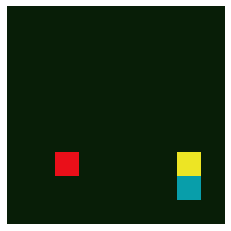

STATE: 1
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


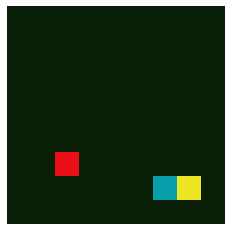

STATE: 2
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


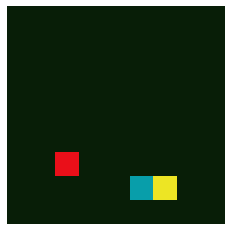

STATE: 3
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


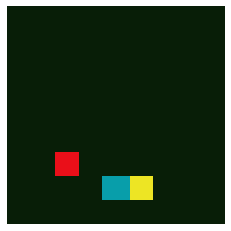

STATE: 4
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


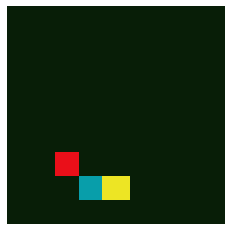

STATE: 5
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: right
Dist proba: None
Reward: 100


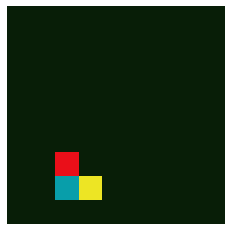

STATE: 6
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: right
Dist proba: None
Reward: -10


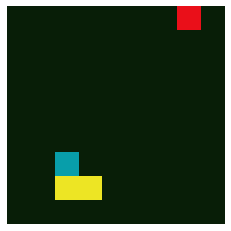

STATE: 7
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


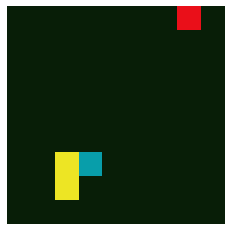

STATE: 8
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


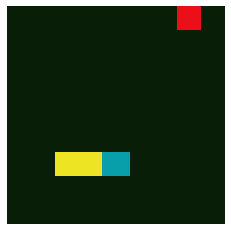

STATE: 9
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


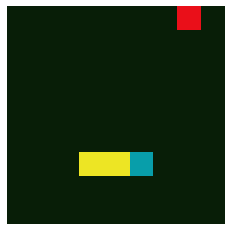

STATE: 10
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


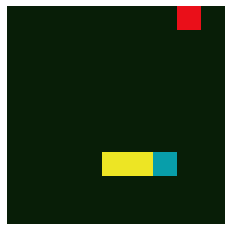

STATE: 11
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: left
Dist proba: None
Reward: -10


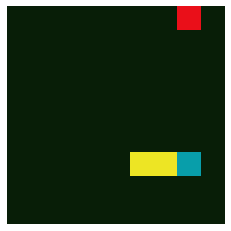

STATE: 12
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


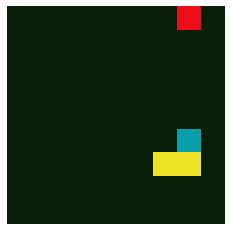

STATE: 13
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


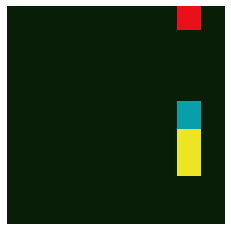

STATE: 14
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


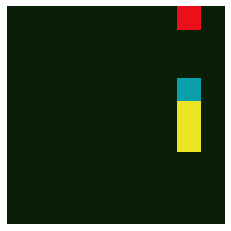

STATE: 15
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


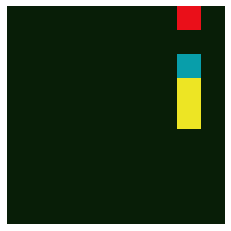

STATE: 16
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


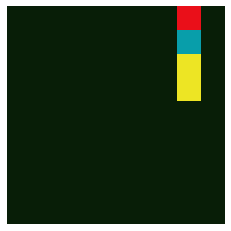

STATE: 17
Feature state :[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
Action: left
Dist proba: None
Reward: -10


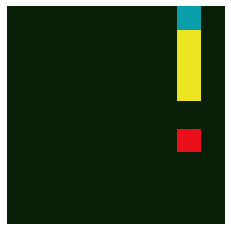

STATE: 18
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
Action: left
Dist proba: None
Reward: -10


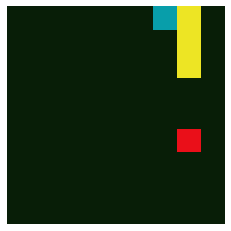

STATE: 19
Feature state :[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
Action: straight
Dist proba: None
Reward: -10


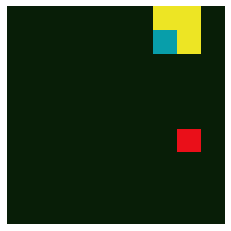

STATE: 20
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Action: left
Dist proba: None
Reward: -10


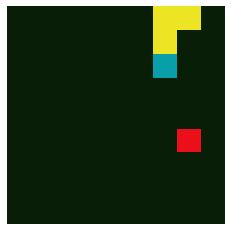

STATE: 21
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: right
Dist proba: None
Reward: -10


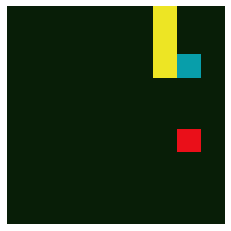

STATE: 22
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


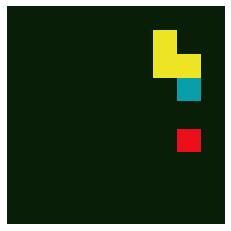

STATE: 23
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: 100


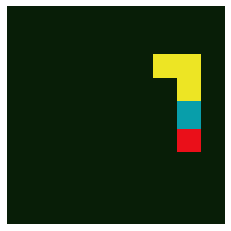

STATE: 24
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


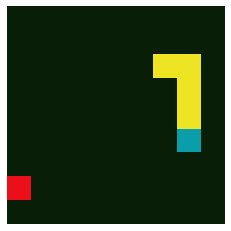

STATE: 25
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


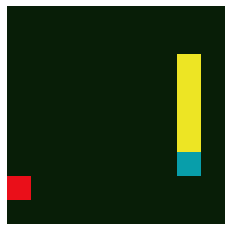

STATE: 26
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Action: right
Dist proba: None
Reward: -10


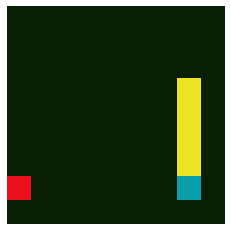

STATE: 27
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


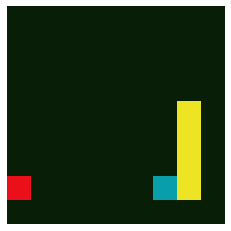

STATE: 28
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


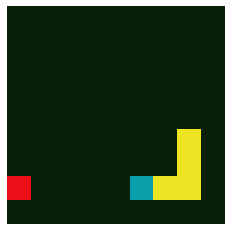

STATE: 29
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


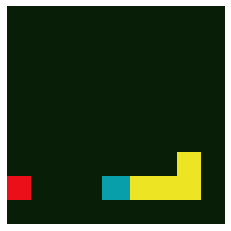

STATE: 30
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


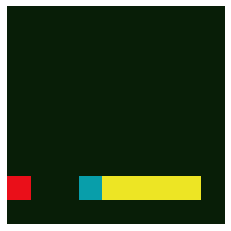

STATE: 31
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


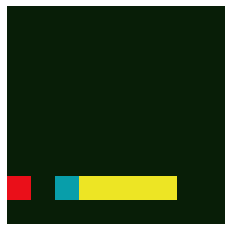

STATE: 32
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


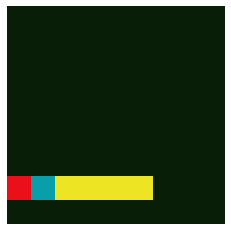

STATE: 33
Feature state :[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Action: right
Dist proba: None
Reward: 100


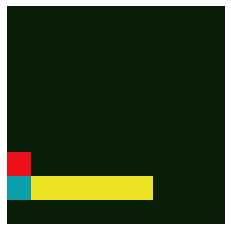

STATE: 34
Feature state :[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


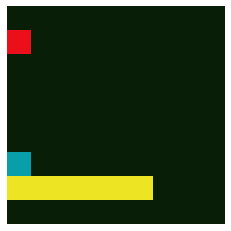

STATE: 35
Feature state :[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


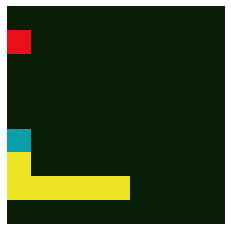

STATE: 36
Feature state :[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


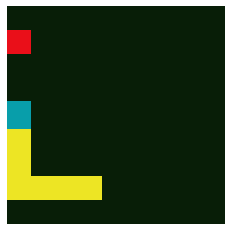

STATE: 37
Feature state :[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


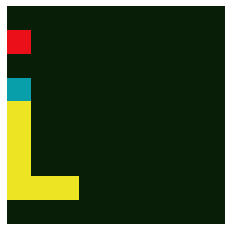

STATE: 38
Feature state :[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


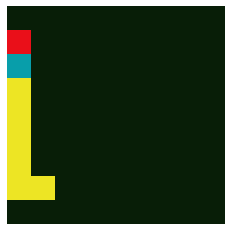

STATE: 39
Feature state :[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
Action: right
Dist proba: None
Reward: -10


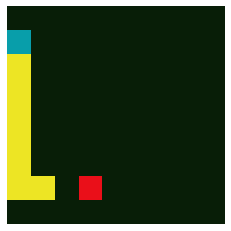

STATE: 40
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
Action: straight
Dist proba: None
Reward: -10


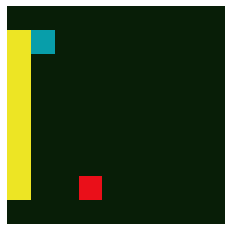

STATE: 41
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
Action: straight
Dist proba: None
Reward: -10


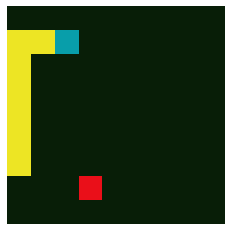

STATE: 42
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: right
Dist proba: None
Reward: -10


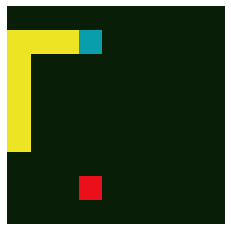

STATE: 43
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


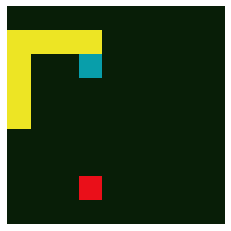

STATE: 44
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


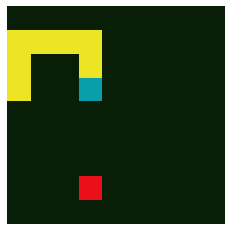

STATE: 45
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


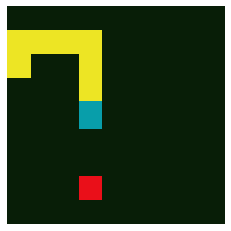

STATE: 46
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


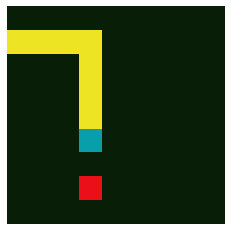

STATE: 47
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: 100


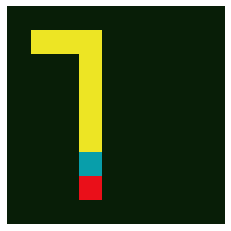

STATE: 48
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: left
Dist proba: None
Reward: -10


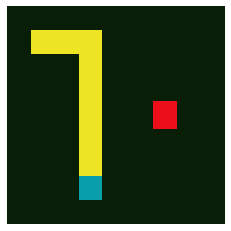

STATE: 49
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


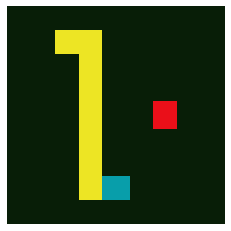

STATE: 50
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


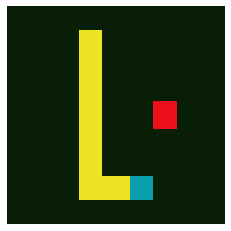

STATE: 51
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: left
Dist proba: None
Reward: -10


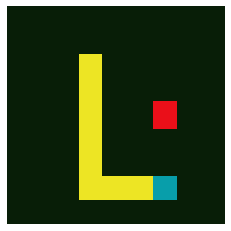

STATE: 52
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


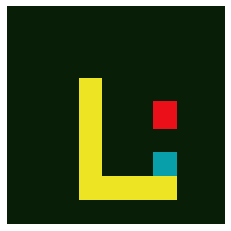

STATE: 53
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


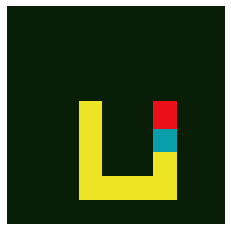

STATE: 54
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


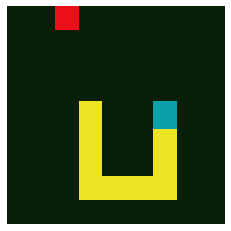

STATE: 55
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


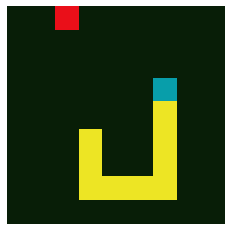

STATE: 56
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


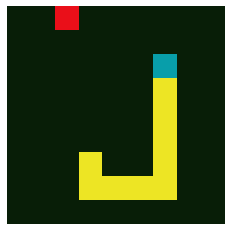

STATE: 57
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


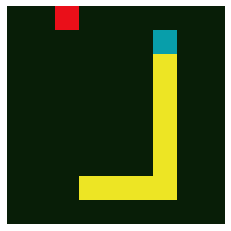

STATE: 58
Feature state :[1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Action: left
Dist proba: None
Reward: -10


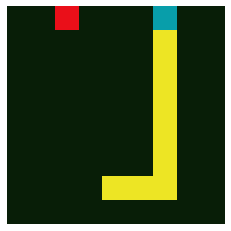

STATE: 59
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


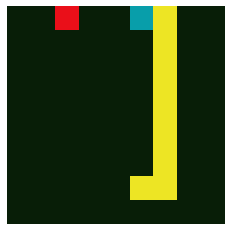

STATE: 60
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


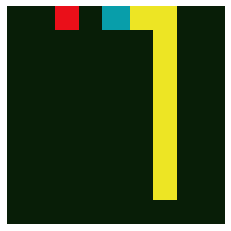

STATE: 61
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


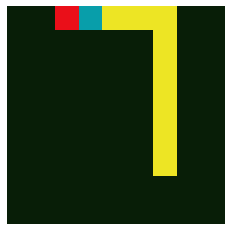

STATE: 62
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


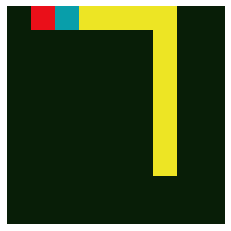

STATE: 63
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
Action: left
Dist proba: None
Reward: -10


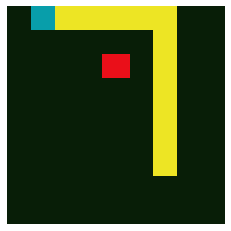

STATE: 64
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Action: left
Dist proba: None
Reward: -10


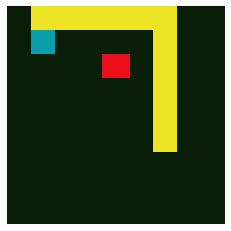

STATE: 65
Feature state :[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.]
Action: straight
Dist proba: None
Reward: -10


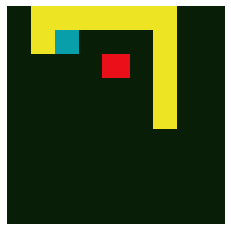

STATE: 66
Feature state :[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.]
Action: straight
Dist proba: None
Reward: -10


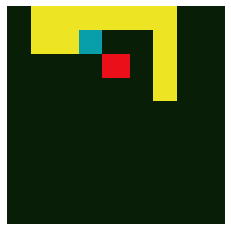

STATE: 67
Feature state :[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.]
Action: right
Dist proba: None
Reward: 100


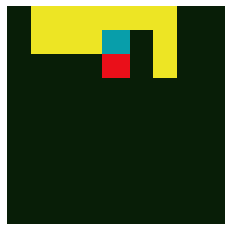

STATE: 68
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Action: left
Dist proba: None
Reward: -10


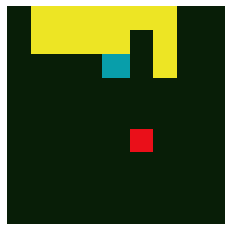

STATE: 69
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: right
Dist proba: None
Reward: -10


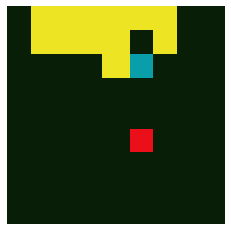

STATE: 70
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


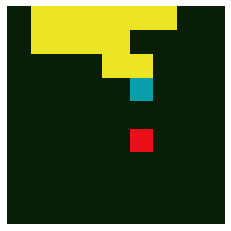

STATE: 71
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: 100


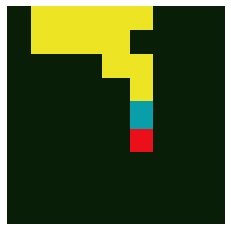

STATE: 72
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: right
Dist proba: None
Reward: -10


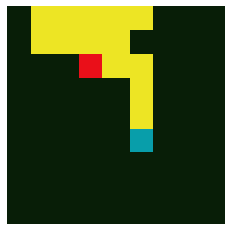

STATE: 73
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


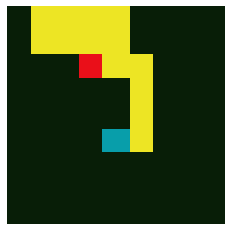

STATE: 74
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: right
Dist proba: None
Reward: -10


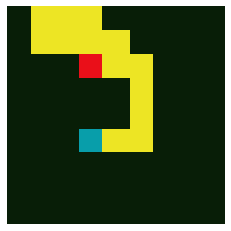

STATE: 75
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


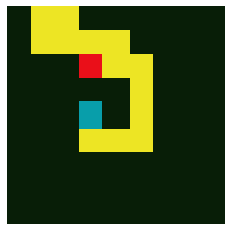

STATE: 76
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


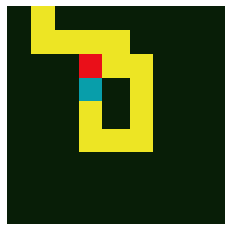

STATE: 77
Feature state :[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
Action: left
Dist proba: None
Reward: -10


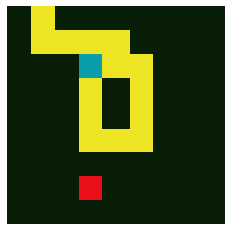

STATE: 78
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
Action: left
Dist proba: None
Reward: -10


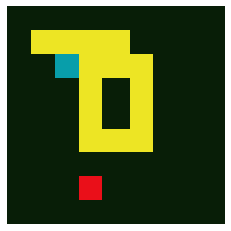

STATE: 79
Feature state :[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
Action: straight
Dist proba: None
Reward: -10


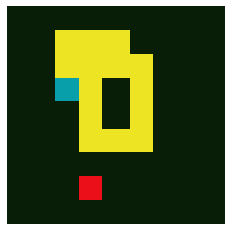

STATE: 80
Feature state :[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
Action: straight
Dist proba: None
Reward: -10


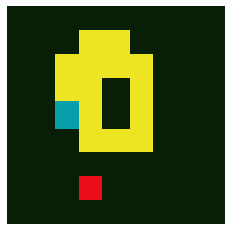

STATE: 81
Feature state :[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
Action: straight
Dist proba: None
Reward: -10


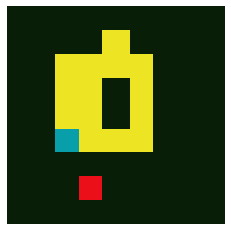

STATE: 82
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Action: left
Dist proba: None
Reward: -10


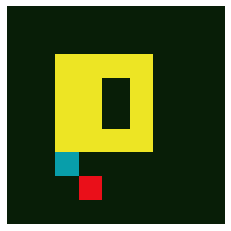

STATE: 83
Feature state :[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.]
Action: right
Dist proba: None
Reward: 100


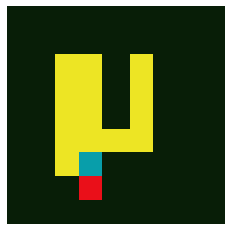

STATE: 84
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: left
Dist proba: None
Reward: -10


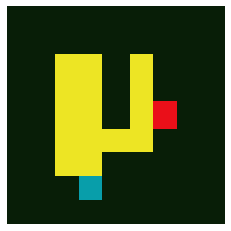

STATE: 85
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


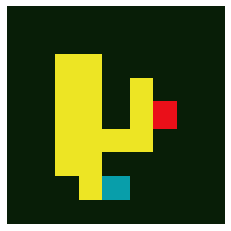

STATE: 86
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


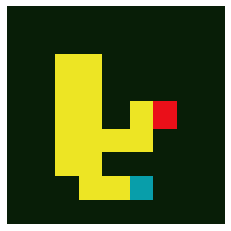

STATE: 87
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: left
Dist proba: None
Reward: -10


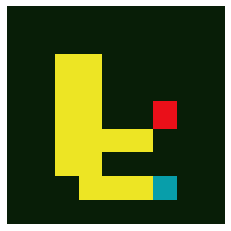

STATE: 88
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


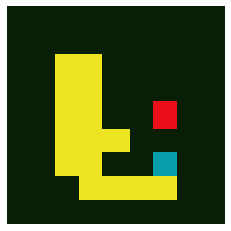

STATE: 89
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


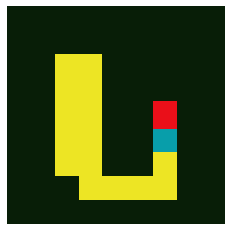

STATE: 90
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: left
Dist proba: None
Reward: -10


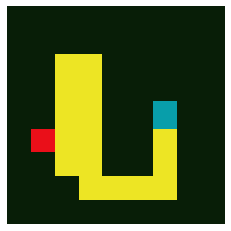

STATE: 91
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


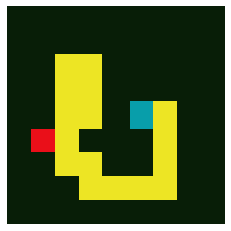

STATE: 92
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


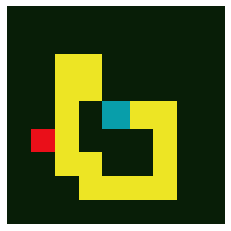

STATE: 93
Feature state :[0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
Action: right
Dist proba: None
Reward: -10


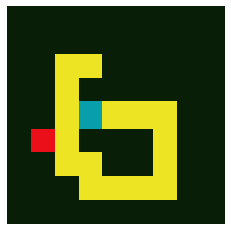

STATE: 94
Feature state :[1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


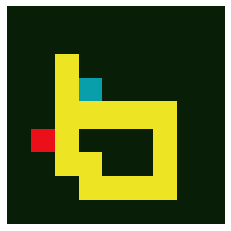

STATE: 95
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: left
Dist proba: None
Reward: -10


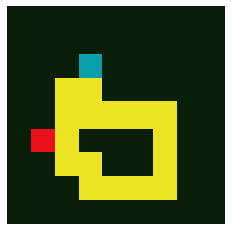

STATE: 96
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


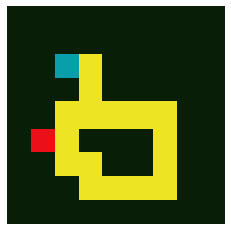

STATE: 97
Feature state :[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: left
Dist proba: None
Reward: -10


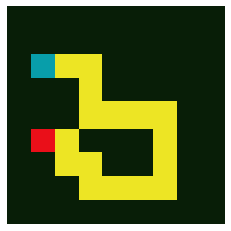

STATE: 98
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


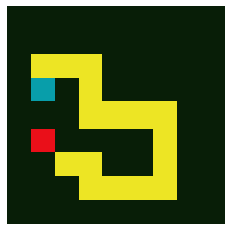

STATE: 99
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: 100


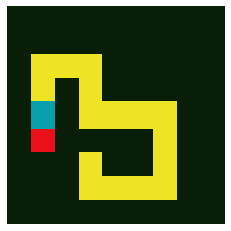

STATE: 100
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: straight
Dist proba: None
Reward: 100


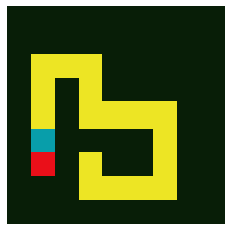

STATE: 101
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: left
Dist proba: None
Reward: -10


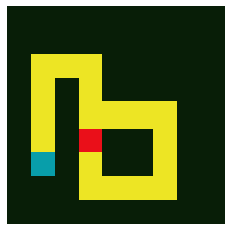

STATE: 102
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


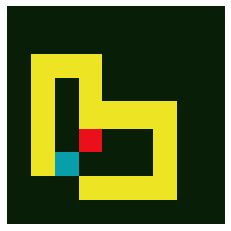

STATE: 103
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: left
Dist proba: None
Reward: 100


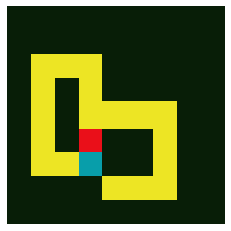

STATE: 104
Feature state :[1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
Action: right
Dist proba: None
Reward: -10


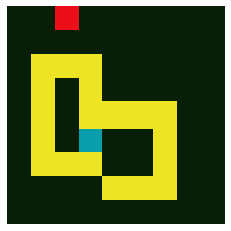

STATE: 105
Feature state :[0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


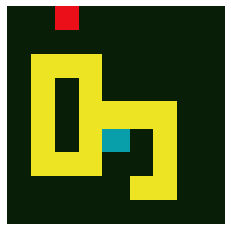

STATE: 106
Feature state :[0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.]
Action: right
Dist proba: None
Reward: -10


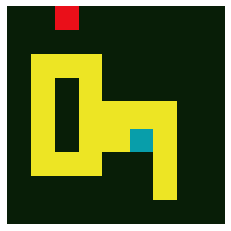

STATE: 107
Feature state :[0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
Action: right
Dist proba: None
Reward: -10


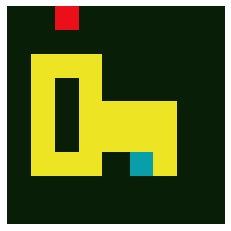

STATE: 108
Feature state :[0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
Action: left
Dist proba: None
Reward: -10


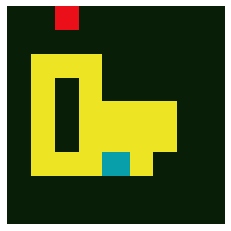

STATE: 109
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Action: right
Dist proba: None
Reward: -10


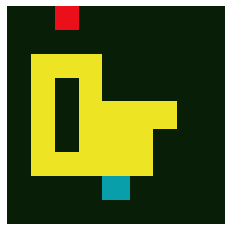

STATE: 110
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


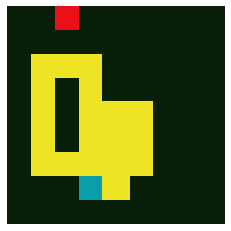

STATE: 111
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: -10


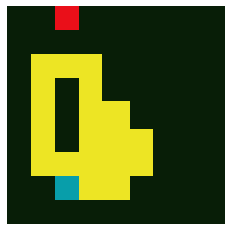

STATE: 112
Feature state :[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


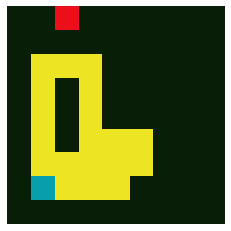

STATE: 113
Feature state :[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
Action: right
Dist proba: None
Reward: -10


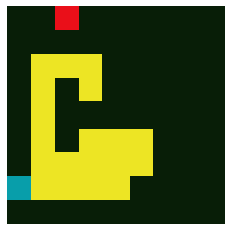

STATE: 114
Feature state :[1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


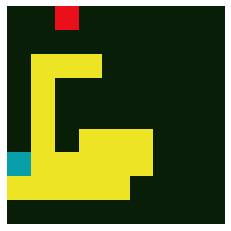

STATE: 115
Feature state :[1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


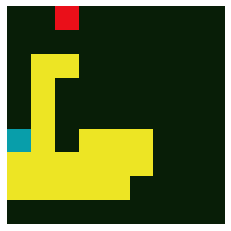

STATE: 116
Feature state :[1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


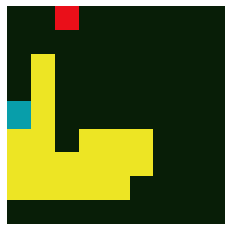

STATE: 117
Feature state :[1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


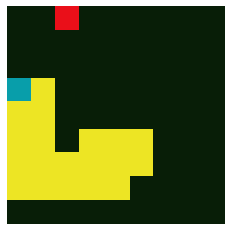

STATE: 118
Feature state :[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
Action: right
Dist proba: None
Reward: -10


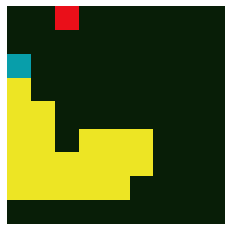

STATE: 119
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Action: straight
Dist proba: None
Reward: -10


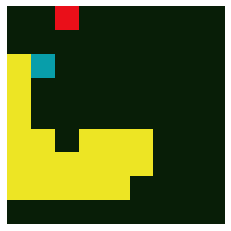

STATE: 120
Feature state :[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: left
Dist proba: None
Reward: -10


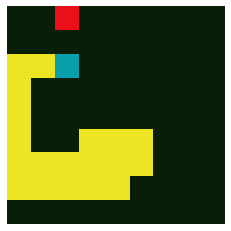

STATE: 121
Feature state :[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


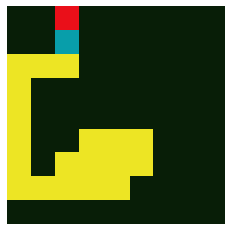

STATE: 122
Feature state :[1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
Action: right
Dist proba: None
Reward: -10


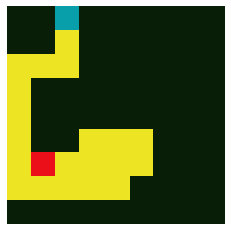

STATE: 123
Feature state :[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.]
Action: right
Dist proba: None
Reward: -10


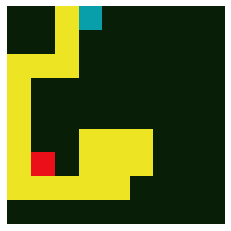

STATE: 124
Feature state :[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


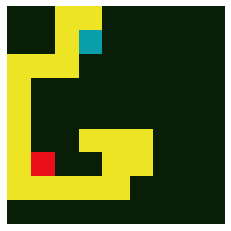

STATE: 125
Feature state :[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


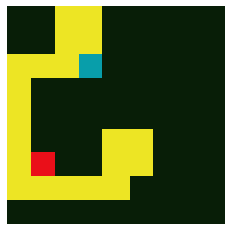

STATE: 126
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


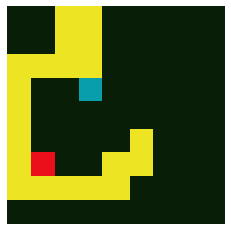

STATE: 127
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


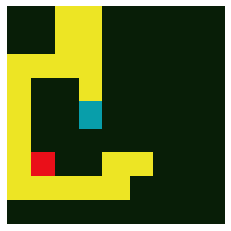

STATE: 128
Feature state :[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Action: straight
Dist proba: None
Reward: -10


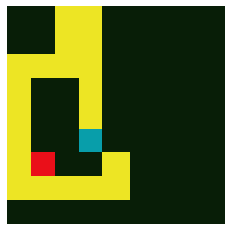

STATE: 129
Feature state :[0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
Action: right
Dist proba: None
Reward: -10


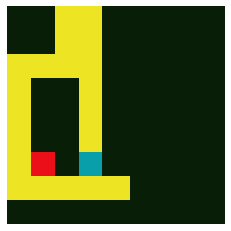

STATE: 130
Feature state :[0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
Action: straight
Dist proba: None
Reward: 100


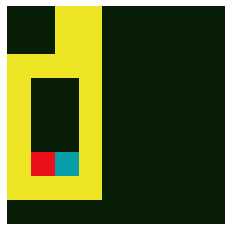

STATE: 131
Feature state :[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
Action: right
Dist proba: None
Reward: -10


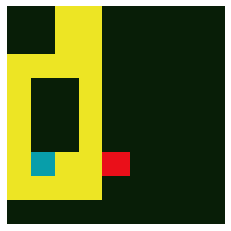

STATE: 132
Feature state :[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
Action: right
Dist proba: None
Reward: -10


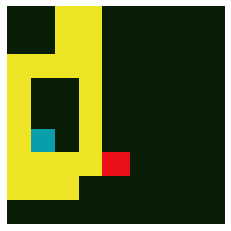

STATE: 133
Feature state :[0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1.]
Action: left
Dist proba: None
Reward: -10


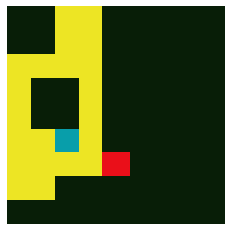

STATE: 134
Feature state :[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
Action: left
Dist proba: None
Reward: -10


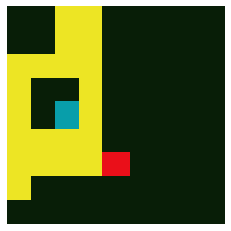

STATE: 135
Feature state :[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.]
Action: right
Dist proba: None
Reward: -10


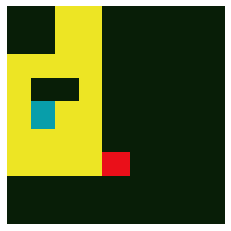

STATE: 136
Feature state :[1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
Action: right
Dist proba: None
Reward: -10


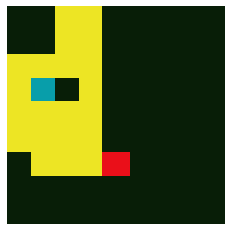

STATE: 137
Feature state :[0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1.]
Action: right
Dist proba: None
Reward: -500


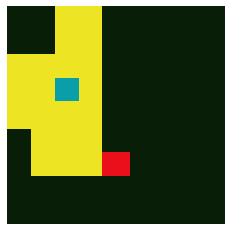

DEAD at state t=138 with score=330 with length Snake=22


(330, 22, 138, array([0.62318841, 0.17391304, 0.20289855]))

In [20]:
# run a game of snake with your agent
agent.run(debug=True, pretty_display=True)

In [21]:
# train your agent - you can repeat this action as you wish. Learning is cumulative here.
agent.train(epochs=5, batch_size=1, n_learning_iter=50, n_learning_iter_dying=10)

100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


In [ ]:
# run a game of snake AFTER training and choose only legitimate action (inference true)
agent.run(debug=True, pretty_display=True, inference=True, video=False)

In [ ]:
# do not hesitate to modify these parameters to adjust the learning as it goes
#agent.policy.explor_proba = 0.01
#agent.policy.lr = 1e-5

In [ ]:
# save the Q-Table (brain) of the Snake Agent
#date = datetime.now().strftime("%m-%d-%Y")
#with open(f'../models/{LEARNING_STYLE}/qtable-dying-{date}.npy', 'wb') as f:
#    np.save(f, np.array(agent.policy.qtable))

In [15]:
# load your table and place it in your agent
#loaded_qtable = pd.DataFrame(np.load(f"../models/{LEARNING_STYLE}/qtable-dying.npy"))
#agent.policy.qtable = loaded_qtable